### Psytrack Notebook

In [1]:
import os
import re
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from oneibl.onelight import ONE
import wget
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1

ibl_data_path = '../data_IBL'



In [29]:
# Downloading data, then unzipping manually in folder, then preprocessing with below code from Psytrack notebook

# current_cwd = os.getcwd()
# SPATH = current_cwd + "/Figures"
# ibl_data_path = SPATH + '/ibl-behavioral-data-Dec2019'
# # os.chdir(ibl_data_path)
# # print(os.getcwd())

# # import subprocess

# # def runcmd(cmd, verbose = False, *args, **kwargs):

# #     process = subprocess.Popen(
# #         cmd,
# #         stdout = subprocess.PIPE,
# #         stderr = subprocess.PIPE,
# #         text = True,
# #         shell = True
# #     )
# #     std_out, std_err = process.communicate()
# #     if verbose:
# #         print(std_out.strip(), std_err)
# #     pass

# # runcmd('echo "Hello, World!"', verbose = True)

# # runcmd("wget https://ndownloader.figshare.com/files/21623715", verbose = True)

# # Search all sessions that have these dataset types.
# required_vars = ['_ibl_trials.choice', '_ibl_trials.contrastLeft',
#                  '_ibl_trials.contrastRight','_ibl_trials.feedbackType']
# one = ONE()
# eids = one.search(required_vars)

# mouseData = pd.DataFrame()
# for eid in eids:
#     lab, _, subject, date, session = eid.split("/")    
#     sess_vars = {
#         "eid": eid,
#         "lab": lab,
#         "subject": subject,
#         "date": date,
#         "session": session,
#     }
#     mouseData = mouseData.append(sess_vars, sort=True, ignore_index=True)

# all_vars = ["contrastLeft", "contrastRight", "choice", "feedbackType", "probabilityLeft"]
# df = pd.DataFrame()

# all_mice = []
# for j, s in enumerate(mouseData["subject"].unique()):
#     print("\rProcessing " + str(j+1) + " of " + str(len(mouseData["subject"].unique())), end="")
#     mouse = mouseData[mouseData["subject"]==s].sort_values(['date', 'session']).reset_index()
#     for i, row in mouse.iterrows():
#         myVars = {}
#         for v in all_vars:
#             filename = "_ibl_trials." + v + ".npy"
#             var_file = os.path.join(ibl_data_path, row.eid, "alf", filename)
#             myVars[v] = list(np.load(var_file).flatten())

#         num_trials = len(myVars[v])
#         myVars['lab'] = [row.lab]*num_trials
#         myVars['subject'] = [row.subject]*num_trials
#         myVars['date'] = [row.date]*num_trials
#         myVars['session'] = [row.session]*num_trials

#         all_mice += [pd.DataFrame(myVars, columns=myVars.keys())]
        
# df = pd.concat(all_mice, ignore_index=True)

# df = df[df['choice'] != 0]        # dump mistrials
# df = df[df['feedbackType'] != 0]  # 3 anomalous trials from ZM_1084, omit
# df.loc[np.isnan(df['contrastLeft']), "contrastLeft"] = 0
# df.loc[np.isnan(df['contrastRight']), "contrastRight"] = 0
# df.loc[df["contrastRight"] < 0, "contrastLeft"] = np.abs(df.loc[df["contrastRight"] < 0, "contrastRight"])
# df.loc[df["contrastRight"] < 0, "contrastRight"] = 0  # 81 anomalous trials in CSHL_002, correct
# df["correctSide"] = df["feedbackType"] * df["choice"]      # new column to indicate correct answer
# df.loc[df["correctSide"]==1, "correctSide"] = 0
# df.loc[df["correctSide"]==-1, "correctSide"] = 1
# df.loc[df["feedbackType"]==-1, "feedbackType"] = 0
# df.loc[df["choice"]==1, "choice"] = 0
# df.loc[df["choice"]==-1, "choice"] = 1
# df.to_csv(SPATH+"ibl_processed.csv", index=False)

Processing 101 of 101

In [36]:
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')

In [37]:
dfAll.head()

,contrastLeft,contrastRight,choice,feedbackType,probabilityLeft,lab,subject,date,session,correctSide
0,1.0,0.0,1,0,1.0,angelakilab,IBL-T1,2019-02-09,1,0
1,1.0,0.0,1,0,1.0,angelakilab,IBL-T1,2019-02-09,1,0
2,0.0,1.0,1,1,1.0,angelakilab,IBL-T1,2019-02-09,1,1
3,0.5,0.0,0,1,0.5,angelakilab,IBL-T1,2019-02-09,1,0
4,0.5,0.0,0,1,0.9,angelakilab,IBL-T1,2019-02-09,1,0


In [38]:
print("contrastLeft: ", np.unique(dfAll['contrastLeft']))   # [0, 0.0625, 0.125, 0.25, 0.5, 1.0] and [0.04, 0.08]
print("contrastRight: ", np.unique(dfAll['contrastRight'])) # [0, 0.0625, 0.125, 0.25, 0.5, 1.0] and [0.04, 0.08]
print("choice: ", np.unique(dfAll['choice']))               # [0, 1]
print("feedbackType: ", np.unique(dfAll['feedbackType']))   # [0, 1]
print("correctSide: ", np.unique(dfAll['correctSide']))               # [0, 1]
print("lab: ", np.unique(dfAll['lab']))
print("subject: ", np.unique(dfAll['subject']))
subjects = np.unique(dfAll['subject'])

contrastLeft:  [0.     0.04   0.0625 0.08   0.125  0.25   0.5    1.    ]
contrastRight:  [0.     0.04   0.0625 0.08   0.125  0.25   0.5    1.    ]
choice:  [0 1]
feedbackType:  [0 1]
correctSide:  [0 1]
lab:  ['angelakilab' 'churchlandlab' 'cortexlab' 'danlab' 'hoferlab' 'mainenlab'
 'mrsicflogellab' 'wittenlab' 'zadorlab']
subject:  ['CSHL049' 'CSHL_001' 'CSHL_002' 'CSHL_003' 'CSHL_004' 'CSHL_005'
 'CSHL_006' 'CSHL_007' 'CSHL_008' 'CSHL_010' 'CSHL_012' 'CSHL_014'
 'CSHL_015' 'CSH_ZAD_001' 'CSH_ZAD_002' 'CSH_ZAD_003' 'CSH_ZAD_004'
 'CSH_ZAD_005' 'CSH_ZAD_006' 'CSH_ZAD_007' 'CSH_ZAD_010' 'DY_001' 'DY_002'
 'DY_003' 'DY_005' 'DY_006' 'DY_007' 'DY_009' 'DY_010' 'DY_011' 'IBL-T1'
 'IBL-T2' 'IBL-T3' 'IBL-T4' 'IBL_001' 'IBL_002' 'KS002' 'KS003' 'KS004'
 'KS005' 'KS014' 'KS015' 'KS016' 'KS017' 'KS018' 'KS019' 'KS020' 'KS021'
 'KS022' 'KS023' 'KS024' 'KS025' 'NYU-01' 'NYU-02' 'NYU-04' 'NYU-06'
 'NYU-07' 'NYU-09' 'NYU-12' 'NYU-13' 'SWC_001' 'SWC_008' 'SWC_012'
 'SWC_013' 'SWC_014' 'SWC_015' 'SW

In [39]:
subjectsWitten = np.unique(dfAll[dfAll['lab'] == 'wittenlab']['subject'])
print(subjectsWitten)

['ibl_witten_02' 'ibl_witten_03' 'ibl_witten_04' 'ibl_witten_05'
 'ibl_witten_06' 'ibl_witten_07' 'ibl_witten_12' 'ibl_witten_13'
 'ibl_witten_14' 'ibl_witten_15' 'ibl_witten_16']


In [40]:


d = getMouse(dfAll, subject='ibl_witten_15', p=5)
print(np.unique(d['date']))

['2019-08-08' '2019-08-09' '2019-08-12' '2019-08-13' '2019-08-14'
 '2019-08-15' '2019-08-16' '2019-08-19' '2019-08-20' '2019-08-21'
 '2019-08-22' '2019-08-23' '2019-08-26' '2019-08-27' '2019-08-28'
 '2019-08-29' '2019-08-30' '2019-09-09' '2019-09-10' '2019-09-11'
 '2019-09-12' '2019-09-13' '2019-09-16' '2019-09-17' '2019-09-18'
 '2019-09-19' '2019-09-23' '2019-09-24' '2019-09-25' '2019-09-26'
 '2019-09-27' '2019-09-30' '2019-10-03' '2019-10-04' '2019-10-07'
 '2019-10-08' '2019-10-09' '2019-10-10' '2019-10-11' '2019-10-14'
 '2019-10-15' '2019-10-16' '2019-10-17' '2019-10-23' '2019-10-24'
 '2019-10-28' '2019-10-29' '2019-10-30' '2019-10-31' '2019-11-01'
 '2019-11-04' '2019-11-05' '2019-11-06' '2019-11-07' '2019-11-08'
 '2019-11-11' '2019-11-12' '2019-11-13' '2019-11-14' '2019-11-15'
 '2019-11-18' '2019-11-19' '2019-11-20' '2019-11-21' '2019-11-22'
 '2019-11-25' '2019-11-26' '2019-11-27']


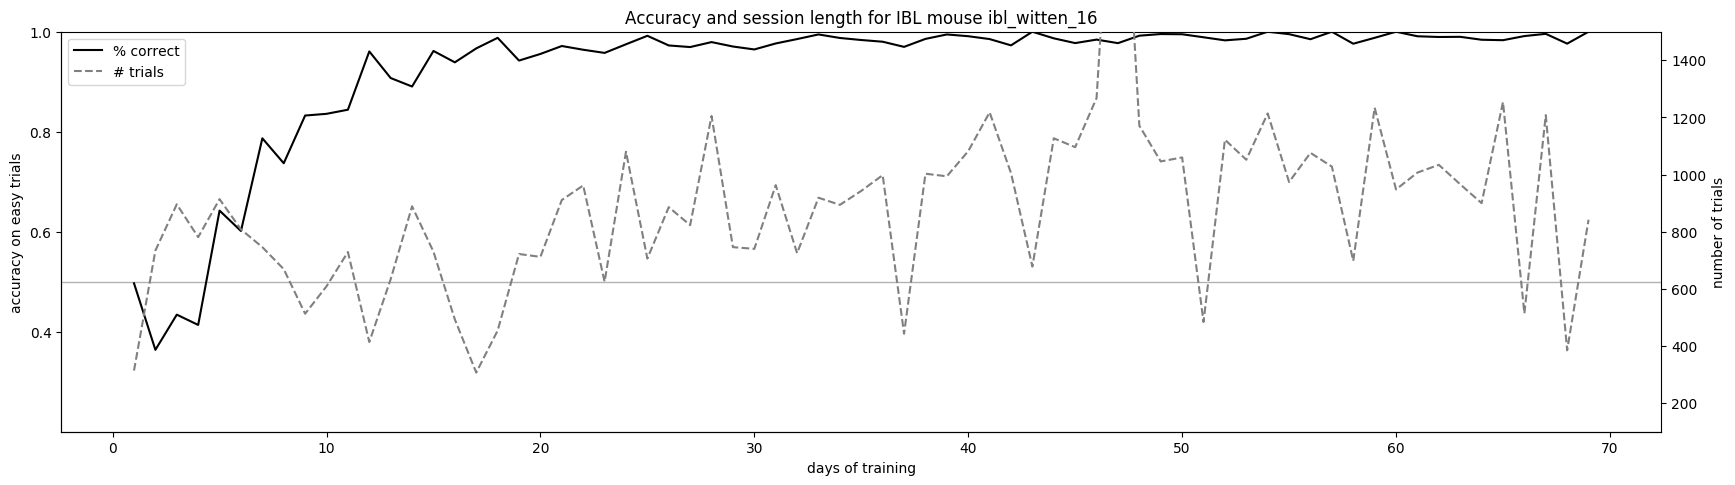

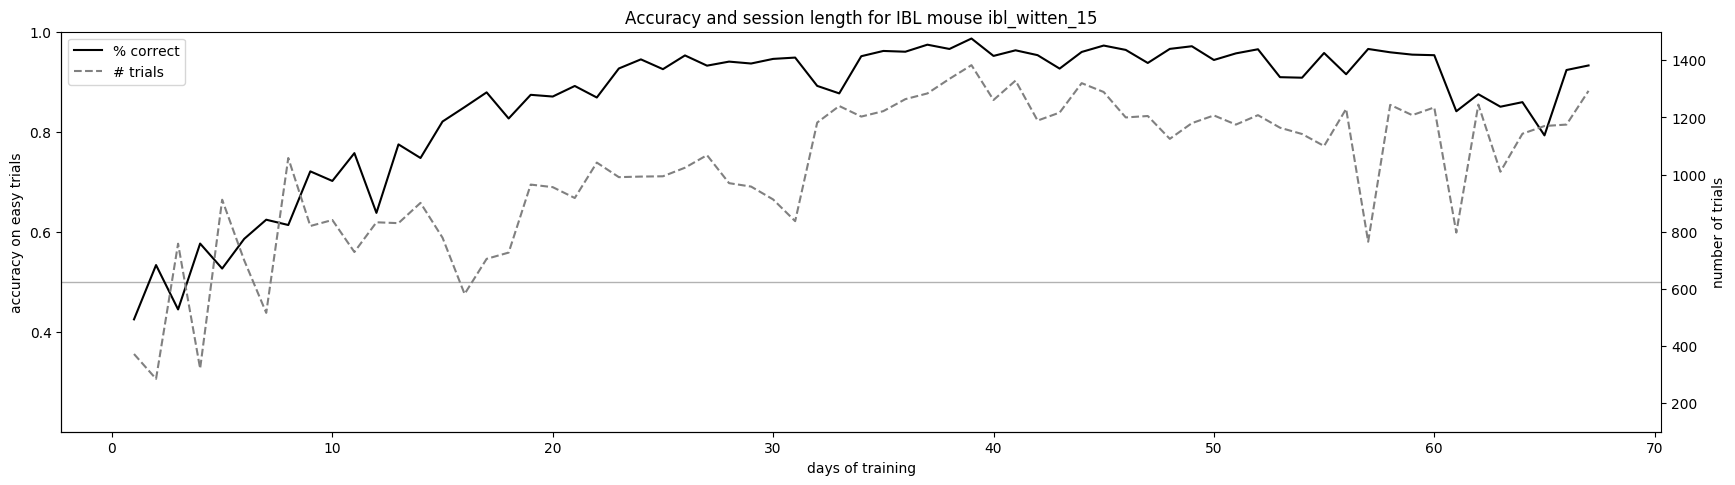

In [79]:

for subject in ['ibl_witten_16','ibl_witten_15']: #subjectsWitten: 
    fig = plt.figure(figsize=(16,4))
    ax1 = plt.subplot()
    ax2 = ax1.twinx()
    axes = [ax1,ax2]
    IBL_plot_performance(dfAll, subject=subject, axes=axes, sessStop=-1)


In [2]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)



    

### Fitting K=1 dGLM-HMM1

In [8]:
subject = 'ibl_witten_15'
x, y, sessInd = get_mouse_design(dfAll, subject)

sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 

K = 1
nfolds = 4
maxiter = 300
L2penaltyW = 1
save = True

D = x.shape[1]
C = 2 # only looking at binomial classes  
N = x.shape[0]
oneSessInd = [0,N] # treating whole dataset as one session for normal GLM-HMM fitting
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
y = y.astype(int)

trainLl = np.zeros((len(sigmaList), maxiter)) 
testLl = np.zeros((len(sigmaList))) 
allP = np.zeros((len(sigmaList), K,K))  
allW = np.zeros((len(sigmaList), N,K,D,C))

for indSigma in range(0,len(sigmaList)): 
    print("Sigma Index " + str(indSigma))
    if (indSigma == 0): 
        initP0, initW0 = dGLM_HMM.generate_param(sessInd=oneSessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)])              
        allP[indSigma],  allW[indSigma], trainLl[indSigma] = dGLM_HMM.fit(x, y,  initP0, initW0, sigma=reshapeSigma(1, K, D), sessInd=oneSessInd, pi0=None, maxIter=maxiter, tol=1e-3, L2penaltyW=L2penaltyW, priorDirP = None) # fit the model
       
    else:
        # initializing from previoous fit
        initP = allP[indSigma-1] 
        initW = allW[indSigma-1] 
            
        # fitting dGLM-HMM
        allP[indSigma],  allW[indSigma], trainLl[indSigma] = dGLM_HMM.fit(x, y,  initP, initW, sigma=reshapeSigma(sigmaList[indSigma], K, D), sessInd=sessInd, pi0=None, maxIter=maxiter, tol=1e-3, L2penaltyW=L2penaltyW, priorDirP = None) # fit the model
       
    # evaluate - test is same as train here
    sess = len(sessInd) - 1 # number sessions
    testPhi = dGLM_HMM.observation_probability(x, reshapeWeights(allW[indSigma], sessInd, sessInd))
    for s in range(0, sess):
        # evaluate on test data for each session separately
        _, _, temp = dGLM_HMM.forward_pass(y[sessInd[s]:sessInd[s+1]],allP[indSigma],testPhi[sessInd[s]:sessInd[s+1]])
        testLl[indSigma] += temp
        
    testLl[indSigma] = testLl[indSigma] / sessInd[-1] # normalizing to the total number of trials in test dataset
    print(testLl[indSigma])

    if(save==True):
        np.save(f'../data_IBL/testLl_IBL_{subject}_{K}-state_multiple_sigmas_L2penaltyW={L2penaltyW}', testLl)
        np.save(f'../data_IBL/P_IBL_{subject}_{K}-state_multiple_sigmas_L2penaltyW={L2penaltyW}', allP)
        np.save(f'../data_IBL/W_IBL_{subject}_{K}-state_multiple_sigmas_L2penaltyW={L2penaltyW}', allW)
        np.save(f'../data_IBL/sessInd_IBL_{subject}_{K}-state_multiple_sigmas_L2penaltyW={L2penaltyW}', np.array(sessInd))
    

(36672,)
36672
Sigma Index 0
0
-0.5613048611701619
Sigma Index 1
0
100
200
-0.5605890209238187
Sigma Index 2
0
100
200
-0.5548395614325498
Sigma Index 3
0
100
200
-0.5292203231090616
Sigma Index 4
0
100
200
-0.5080084707328157
Sigma Index 5
0
100
-0.49782420506700803
Sigma Index 6
0
-0.4928786472749667
Sigma Index 7
0
-0.4921704211233582
Sigma Index 8
0
-0.49210000691278727
Sigma Index 9
0
-0.4920932888453858
Sigma Index 10
0
-0.49209265218467235
Sigma Index 11
0
-0.4920925731244838
Sigma Index 12
0
-0.4920925551807317


Text(0.5, 0, 'sigma')

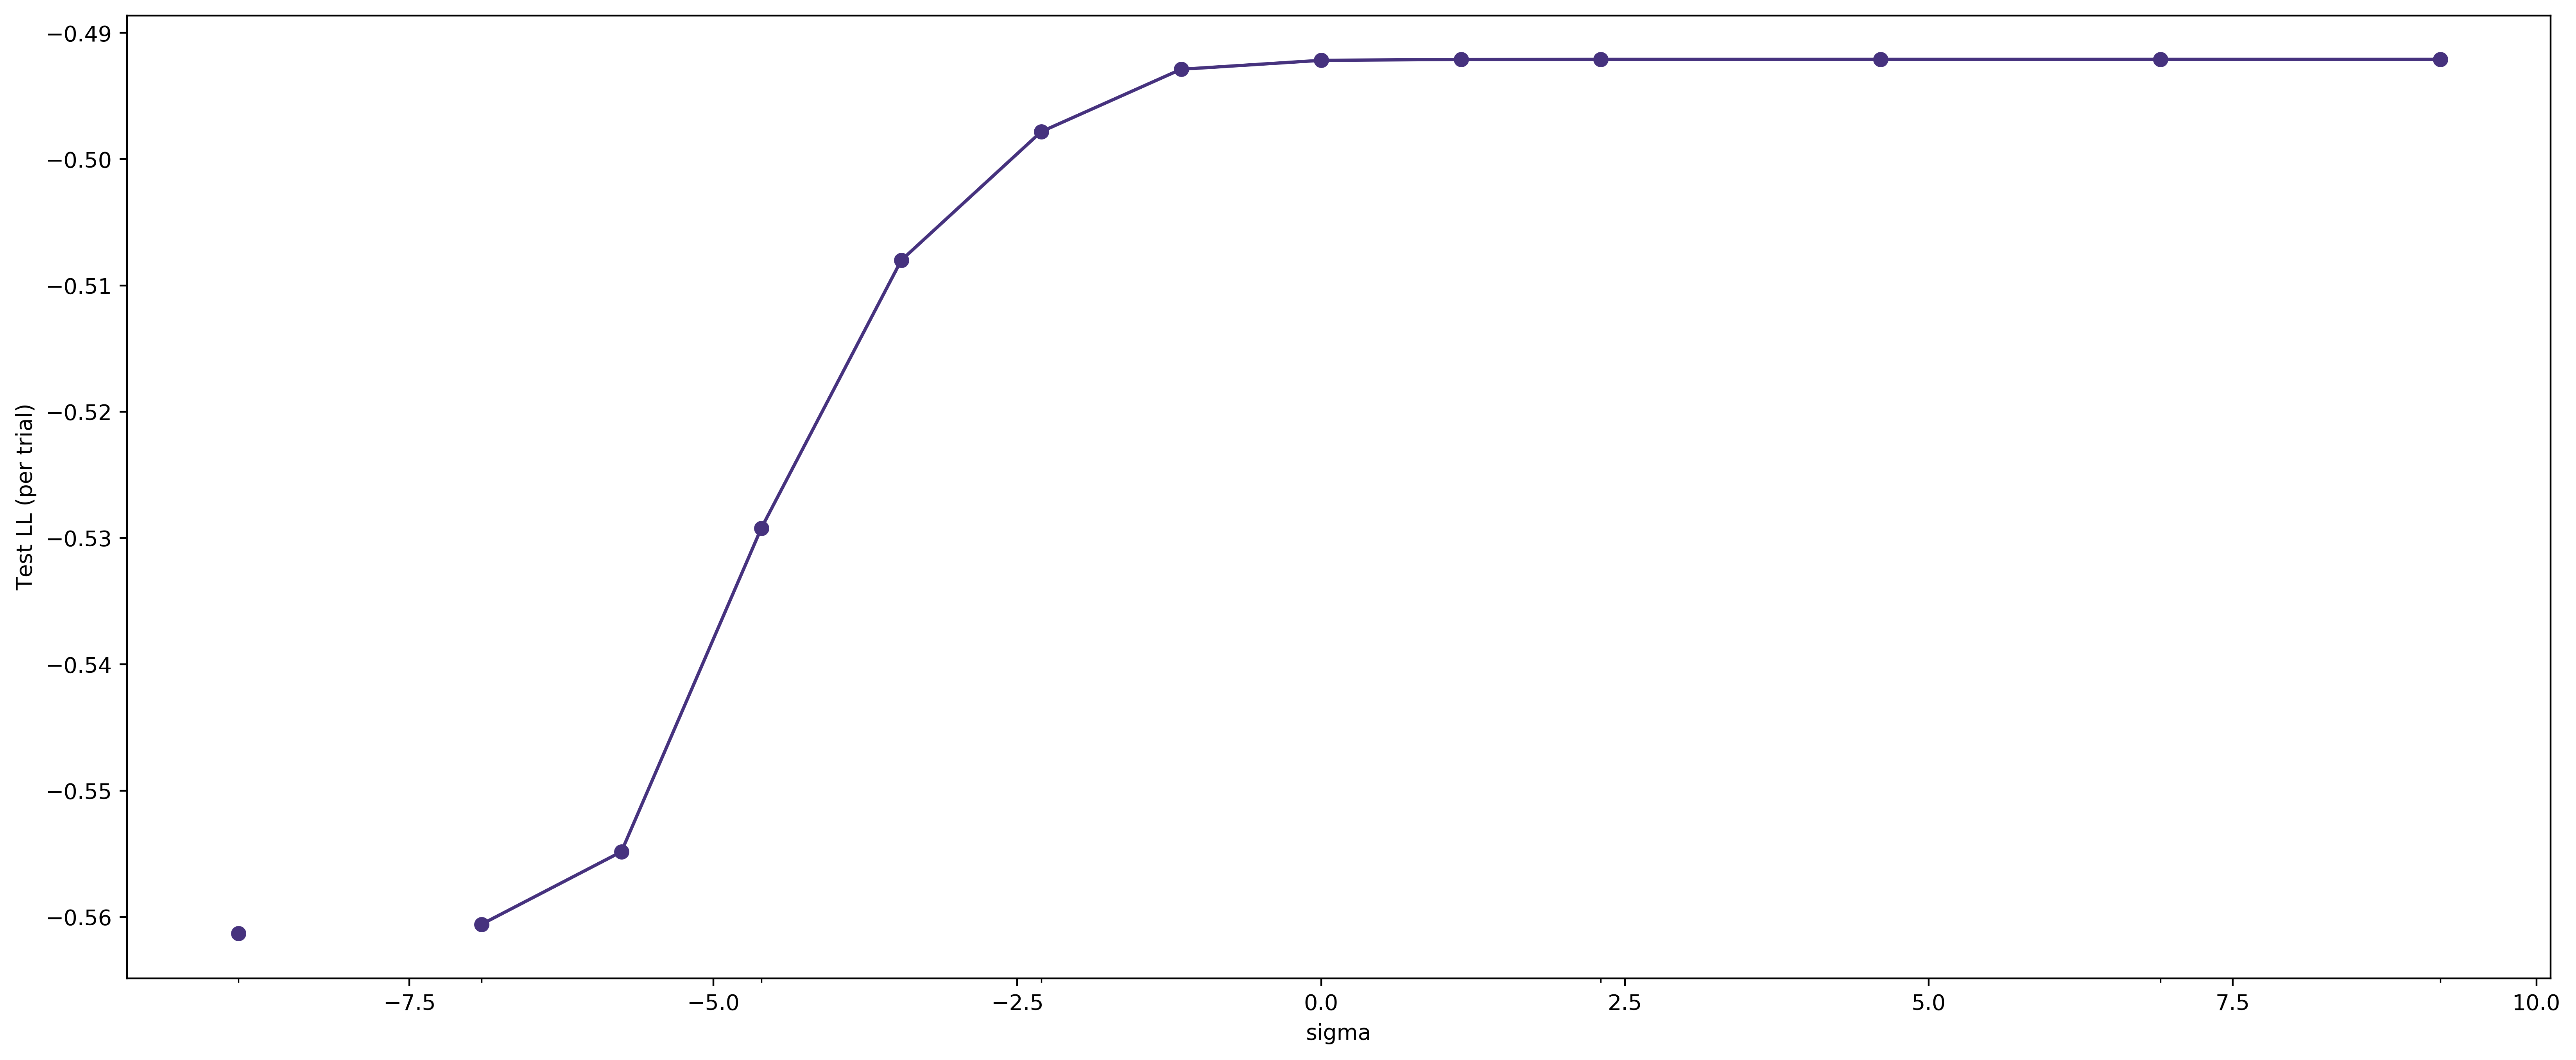

In [17]:
K = 1
colormap = sns.color_palette("viridis")
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
sigmaListEven = [sigmaList[ind] for ind in range(len(sigmaList)) if ind%2==0]
sigmaListOdd = [sigmaList[ind] for ind in range(11) if ind%2==1] + [sigmaList[ind] for ind in range(11,len(sigmaList))]
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
# axes.scatter(np.log(sigmaList[1:]), testLl[1:], color=colormap[color+fold])
axes.plot(np.log(sigmaList[1:]), testLl[1:], '-o', color=colormap[0])
if(sigmaList[0]==0):
    axes.scatter(-2 + np.log(sigmaList[1]), testLl[0], color=colormap[0])
    if (K==1):
        axes.set_xticks([-2 + np.log(sigmaList[1])]+list(np.log(sigmaListOdd)),['GLM'] + [f'{np.round(sigma,4)}' for sigma in sigmaListOdd])
    else:
        axes.set_xticks([-2 + np.log(sigmaList[1])]+list(np.log(sigmaListOdd)),['GLM-HMM'] + [f'{np.round(sigma,4)}' for sigma in sigmaListOdd])
else:
    axes.scatter(np.log(sigmaList[0]), testLl[0], color=colormap[color+fold])
    axes.set_xticks([np.log(sigmaListEven)],[f'{np.round(sigma,4)}' for sigma in sigmaListEven])
axes.set_ylabel("Test LL (per trial)")
axes.set_xlabel("sigma")

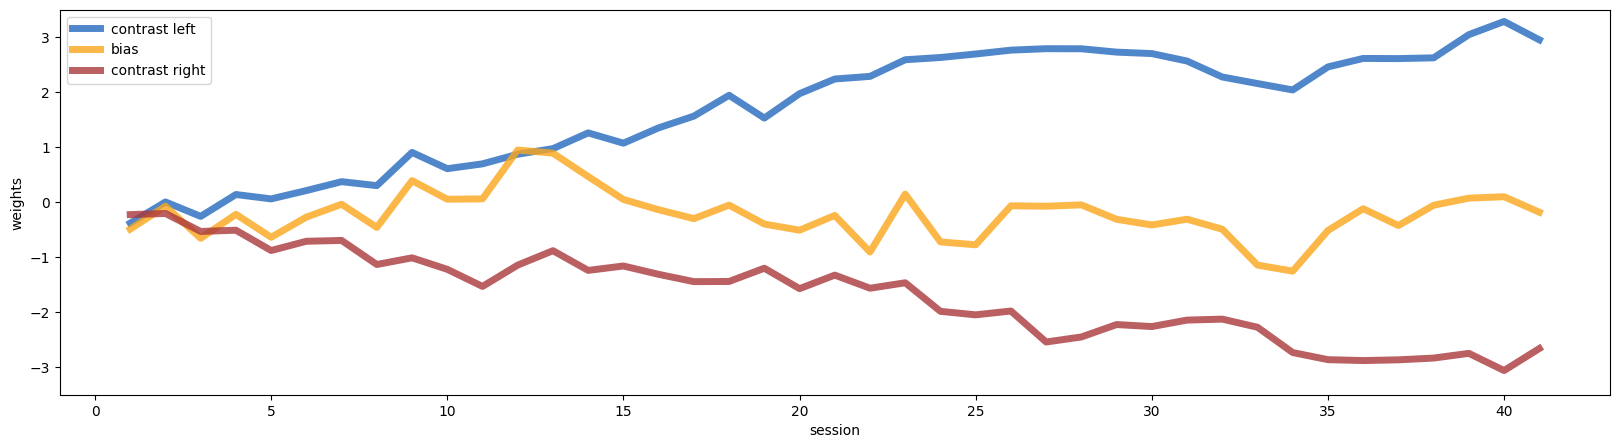

In [25]:
def plotting_weights_IBL(w, sessInd, axes, sessStop=None, title='', save_fig=False):
    K = w.shape[1]
    sess = len(sessInd)-1

    if (K==1):
        if (sessStop==None):
            axes.plot(range(1,sess+1),w[sessInd[:-1],0,1,1],color="#2369BD",linewidth=5,label='contrast left', alpha=0.8)
            axes.plot(range(1,sess+1),w[sessInd[:-1],0,0,1],color='#FAA61A',linewidth=5, label='bias', alpha=0.8)
            axes.plot(range(1,sess+1),w[sessInd[:-1],0,2,1],color="#A9373B",linewidth=5, label='contrast right', alpha=0.8)
        else:
            
            axes.plot(range(1,sessStop+1),w[sessInd[:sessStop],0,1,1],color="#2369BD",linewidth=5,label='contrast left', alpha=0.8)
            axes.plot(range(1,sessStop+1),w[sessInd[:sessStop],0,0,1],color='#FAA61A',linewidth=5, label='bias', alpha=0.8)
            axes.plot(range(1,sessStop+1),w[sessInd[:sessStop],0,2,1],color="#A9373B",linewidth=5, label='contrast right', alpha=0.8)

        axes.set_ylim(-3.5,3.5)
        #axes[0].set_title(title)
        axes.set_ylabel("weights")
        axes.set_xlabel('session')
        # axes[0].set_yticks([-2,0,2])
        # axes[0].set_ylim(-3,3)
        # axes[1].set_ylim(-0.2,2.1)
        # axes[1].set_yticks([0,2])
        #axes[1].set_ylabel("weights")
        axes.set_xlabel('session')

        axes.legend()
        axes.legend()
fig, axes = plt.subplots(1, figsize=(20,5))
plotting_weights_IBL(allW[6],sessInd, axes)

### Fitting K=2 dGLM-HMM1

In [29]:
subject = 'ibl_witten_15'
x, y, sessInd = get_mouse_design(dfAll, subject)

sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 

for K in [2]:
    nfolds = 4
    maxiter = 300
    L2penaltyW = 1
    save = True

    D = x.shape[1]
    C = 2 # only looking at binomial classes  
    N = x.shape[0]
    oneSessInd = [0,N] # treating whole dataset as one session for normal GLM-HMM fitting
    dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
    y = y.astype(int)

    trainLl = np.zeros((len(sigmaList), maxiter)) 
    testLl = np.zeros((len(sigmaList))) 
    allP = np.zeros((len(sigmaList), K,K))  
    allW = np.zeros((len(sigmaList), N,K,D,C))

    for indSigma in range(0,len(sigmaList)): 
        print("Sigma Index " + str(indSigma))
        if (indSigma == 0): 
            allP[0] = np.load(f'../data_IBL/P_IBL_{subject}_bestGLMHMM-Iris_{K}-state.npy')
            allW[0] = np.load(f'../data_IBL/W_IBL_{subject}_bestGLMHMM-Iris_{K}-state.npy')
        else:
            # initializing from previoous fit
            initP = allP[indSigma-1] 
            initW = allW[indSigma-1] 
                
            # fitting dGLM-HMM
            allP[indSigma],  allW[indSigma], trainLl[indSigma] = dGLM_HMM.fit(x, y,  initP, initW, sigma=reshapeSigma(sigmaList[indSigma], K, D), sessInd=sessInd, pi0=None, maxIter=maxiter, tol=1e-3, L2penaltyW=L2penaltyW, priorDirP = None) # fit the model
        
        # evaluate - test is same as train here
        sess = len(sessInd) - 1 # number sessions
        testPhi = dGLM_HMM.observation_probability(x, reshapeWeights(allW[indSigma], sessInd, sessInd))
        for s in range(0, sess):
            # evaluate on test data for each session separately
            _, _, temp = dGLM_HMM.forward_pass(y[sessInd[s]:sessInd[s+1]],allP[indSigma],testPhi[sessInd[s]:sessInd[s+1]])
            testLl[indSigma] += temp
            
        testLl[indSigma] = testLl[indSigma] / sessInd[-1] # normalizing to the total number of trials in test dataset
        print(testLl[indSigma])

        if(save==True):
            np.save(f'../data_IBL/testLl_IBL_{subject}_{K}-state_multiple_sigmas_L2penaltyW={L2penaltyW}', testLl)
            np.save(f'../data_IBL/P_IBL_{subject}_{K}-state_multiple_sigmas_L2penaltyW={L2penaltyW}', allP)
            np.save(f'../data_IBL/W_IBL_{subject}_{K}-state_multiple_sigmas_L2penaltyW={L2penaltyW}', allW)
            np.save(f'../data_IBL/sessInd_IBL_{subject}_{K}-state_multiple_sigmas_L2penaltyW={L2penaltyW}', np.array(sessInd))
    

(36672,)
36672
Sigma Index 0
-0.5012674537088089
Sigma Index 1
0
100
200
-0.5011436036971281
Sigma Index 2
0
100
200
-0.50007252185221
Sigma Index 3
0
100
200
-0.49293431060235376
Sigma Index 4
0
100
200
-0.4779020132090378
Sigma Index 5
0
100
-0.46944226224608937
Sigma Index 6
0
-0.4638797522585932
Sigma Index 7
0
-0.46148428366225785
Sigma Index 8
0
-0.4611631826212215
Sigma Index 9
0
-0.46114809620666697
Sigma Index 10
0
-0.4611557664409384
Sigma Index 11
0
-0.46116069337876986
Sigma Index 12
0
-0.4611625840905604


In [33]:
subject = 'ibl_witten_15'
x, y, sessInd = get_mouse_design(dfAll, subject)

sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 

for K in [3]:
    nfolds = 4
    maxiter = 300
    L2penaltyW = 1
    save = True

    D = x.shape[1]
    C = 2 # only looking at binomial classes  
    N = x.shape[0]
    oneSessInd = [0,N] # treating whole dataset as one session for normal GLM-HMM fitting
    dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
    y = y.astype(int)

    trainLl = np.zeros((len(sigmaList), maxiter)) 
    testLl = np.zeros((len(sigmaList))) 
    allP = np.zeros((len(sigmaList), K,K))  
    allW = np.zeros((len(sigmaList), N,K,D,C))

    for indSigma in range(0,len(sigmaList)): 
        print("Sigma Index " + str(indSigma))
        if (indSigma == 0): 
            allP[0] = np.load(f'../data_IBL/P_IBL_{subject}_bestGLMHMM-Iris_{K}-state.npy')
            allW[0] = np.load(f'../data_IBL/W_IBL_{subject}_bestGLMHMM-Iris_{K}-state.npy')
        else:
            # initializing from previoous fit
            initP = allP[indSigma-1] 
            initW = allW[indSigma-1] 
                
            # fitting dGLM-HMM
            allP[indSigma],  allW[indSigma], trainLl[indSigma] = dGLM_HMM.fit(x, y,  initP, initW, sigma=reshapeSigma(sigmaList[indSigma], K, D), sessInd=sessInd, pi0=None, maxIter=maxiter, tol=1e-3, L2penaltyW=L2penaltyW, priorDirP = None) # fit the model
        
        # evaluate - test is same as train here
        sess = len(sessInd) - 1 # number sessions
        testPhi = dGLM_HMM.observation_probability(x, reshapeWeights(allW[indSigma], sessInd, sessInd))
        for s in range(0, sess):
            # evaluate on test data for each session separately
            _, _, temp = dGLM_HMM.forward_pass(y[sessInd[s]:sessInd[s+1]],allP[indSigma],testPhi[sessInd[s]:sessInd[s+1]])
            testLl[indSigma] += temp
            
        testLl[indSigma] = testLl[indSigma] / sessInd[-1] # normalizing to the total number of trials in test dataset
        print(testLl[indSigma])

        if(save==True):
            np.save(f'../data_IBL/testLl_IBL_{subject}_{K}-state_multiple_sigmas_L2penaltyW={L2penaltyW}', testLl)
            np.save(f'../data_IBL/P_IBL_{subject}_{K}-state_multiple_sigmas_L2penaltyW={L2penaltyW}', allP)
            np.save(f'../data_IBL/W_IBL_{subject}_{K}-state_multiple_sigmas_L2penaltyW={L2penaltyW}', allW)
            np.save(f'../data_IBL/sessInd_IBL_{subject}_{K}-state_multiple_sigmas_L2penaltyW={L2penaltyW}', np.array(sessInd))

(36672,)
36672
Sigma Index 0
-0.48298153142284067
Sigma Index 1
0
100
200
-0.4829511976291791
Sigma Index 2
0
100
200
-0.4826791385449874
Sigma Index 3
0


KeyboardInterrupt: 

In [ ]:
subject = 'ibl_witten_16'
x, y, sessInd = get_mouse_design(dfAll, subject)

sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 

K = 1
nfolds = 4
maxiter = 300
L2penaltyW = 1
save = True

D = x.shape[1]
C = 2 # only looking at binomial classes  
N = x.shape[0]
oneSessInd = [0,N] # treating whole dataset as one session for normal GLM-HMM fitting
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
y = y.astype(int)

trainLl = np.zeros((len(sigmaList), maxiter)) 
testLl = np.zeros((len(sigmaList))) 
allP = np.zeros((len(sigmaList), K,K))  
allW = np.zeros((len(sigmaList), N,K,D,C))

for indSigma in range(0,len(sigmaList)): 
    print("Sigma Index " + str(indSigma))
    if (indSigma == 0): 
        initP0, initW0 = dGLM_HMM.generate_param(sessInd=oneSessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)])              
        allP[indSigma],  allW[indSigma], trainLl[indSigma] = dGLM_HMM.fit(x, y,  initP0, initW0, sigma=reshapeSigma(1, K, D), sessInd=oneSessInd, pi0=None, maxIter=maxiter, tol=1e-3, L2penaltyW=L2penaltyW, priorDirP = None) # fit the model
       
    else:
        # initializing from previoous fit
        initP = allP[indSigma-1] 
        initW = allW[indSigma-1] 
            
        # fitting dGLM-HMM
        allP[indSigma],  allW[indSigma], trainLl[indSigma] = dGLM_HMM.fit(x, y,  initP, initW, sigma=reshapeSigma(sigmaList[indSigma], K, D), sessInd=sessInd, pi0=None, maxIter=maxiter, tol=1e-3, L2penaltyW=L2penaltyW, priorDirP = None) # fit the model
       
    # evaluate - test is same as train here
    sess = len(sessInd) - 1 # number sessions
    testPhi = dGLM_HMM.observation_probability(x, reshapeWeights(allW[indSigma], sessInd, sessInd))
    for s in range(0, sess):
        # evaluate on test data for each session separately
        _, _, temp = dGLM_HMM.forward_pass(y[sessInd[s]:sessInd[s+1]],allP[indSigma],testPhi[sessInd[s]:sessInd[s+1]])
        testLl[indSigma] += temp
        
    testLl[indSigma] = testLl[indSigma] / sessInd[-1] # normalizing to the total number of trials in test dataset
    print(testLl[indSigma])

    if(save==True):
        np.save(f'../data_IBL/testLl_IBL_{subject}_{K}-state_multiple_sigmas_L2penaltyW={L2penaltyW}', testLl)
        np.save(f'../data_IBL/P_IBL_{subject}_{K}-state_multiple_sigmas_L2penaltyW={L2penaltyW}', allP)
        np.save(f'../data_IBL/W_IBL_{subject}_{K}-state_multiple_sigmas_L2penaltyW={L2penaltyW}', allW)
        np.save(f'../data_IBL/sessInd_IBL_{subject}_{K}-state_multiple_sigmas_L2penaltyW={L2penaltyW}', np.array(sessInd))

In [ ]:
subject = 'ibl_witten_16'
x, y, sessInd = get_mouse_design(dfAll, subject)

sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 

for K in [2]:
    nfolds = 4
    maxiter = 300
    L2penaltyW = 1
    save = True

    D = x.shape[1]
    C = 2 # only looking at binomial classes  
    N = x.shape[0]
    oneSessInd = [0,N] # treating whole dataset as one session for normal GLM-HMM fitting
    dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
    y = y.astype(int)

    trainLl = np.zeros((len(sigmaList), maxiter)) 
    testLl = np.zeros((len(sigmaList))) 
    allP = np.zeros((len(sigmaList), K,K))  
    allW = np.zeros((len(sigmaList), N,K,D,C))

    for indSigma in range(0,len(sigmaList)): 
        print("Sigma Index " + str(indSigma))
        if (indSigma == 0): 
            allP[0] = np.load(f'../data_IBL/P_IBL_{subject}_bestGLMHMM-Iris_{K}-state.npy')
            allW[0] = np.load(f'../data_IBL/W_IBL_{subject}_bestGLMHMM-Iris_{K}-state.npy')
        else:
            # initializing from previoous fit
            initP = allP[indSigma-1] 
            initW = allW[indSigma-1] 
                
            # fitting dGLM-HMM
            allP[indSigma],  allW[indSigma], trainLl[indSigma] = dGLM_HMM.fit(x, y,  initP, initW, sigma=reshapeSigma(sigmaList[indSigma], K, D), sessInd=sessInd, pi0=None, maxIter=maxiter, tol=1e-3, L2penaltyW=L2penaltyW, priorDirP = None) # fit the model
        
        # evaluate - test is same as train here
        sess = len(sessInd) - 1 # number sessions
        testPhi = dGLM_HMM.observation_probability(x, reshapeWeights(allW[indSigma], sessInd, sessInd))
        for s in range(0, sess):
            # evaluate on test data for each session separately
            _, _, temp = dGLM_HMM.forward_pass(y[sessInd[s]:sessInd[s+1]],allP[indSigma],testPhi[sessInd[s]:sessInd[s+1]])
            testLl[indSigma] += temp
            
        testLl[indSigma] = testLl[indSigma] / sessInd[-1] # normalizing to the total number of trials in test dataset
        print(testLl[indSigma])

        if(save==True):
            np.save(f'../data_IBL/testLl_IBL_{subject}_{K}-state_multiple_sigmas_L2penaltyW={L2penaltyW}', testLl)
            np.save(f'../data_IBL/P_IBL_{subject}_{K}-state_multiple_sigmas_L2penaltyW={L2penaltyW}', allP)
            np.save(f'../data_IBL/W_IBL_{subject}_{K}-state_multiple_sigmas_L2penaltyW={L2penaltyW}', allW)
            np.save(f'../data_IBL/sessInd_IBL_{subject}_{K}-state_multiple_sigmas_L2penaltyW={L2penaltyW}', np.array(sessInd))